Copyright 2016 Intel Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# fMRI Simulator example script for multivariate analyses

Example script to demonstrate fmrisim functionality. This generates
data for a two condition, event related design in which each condition
evokes different activity within the same voxels. It then runs simple 
univariate and multivariate analyses on the data

Authors: Cameron Ellis (Yale) 2017


### **1.	Set parameters.** 

It is necessary to set various parameters that describe how the signal and the noise will be generated.

*1.1 Import necessary Python packages*

In [2]:
%matplotlib notebook

from pathlib import Path
from brainiak.utils import fmrisim
import nibabel
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_distance
import sklearn.manifold as manifold
import scipy.stats as stats
import sklearn.model_selection
import sklearn.svm

*1.2 Load participant data*

Any 4 dimensional fMRI data that is readible by nibabel can be used as input to this pipeline. For this example, data is taken from the open access repository DataSpace: http://arks.princeton.edu/ark:/88435/dsp01dn39x4181. This file is unzipped and placed in the home directory with the name Corr_MVPA 

In [3]:
home = str(Path.home())
nii = nibabel.load(home + '/Corr_MVPA/Participant_01_rest_run01.nii')
volume = nii.get_data()

*1.2	Specify participant dimensions and resolution*

It is possible to manually specify all parameters necessary for fmrisim. However, it is also possible to instead provide an fMRI dataset as input and extract the necessary parameters from that dataset. Such an example is described below and will be followed throughout. Here the size of the volume and the resolution of the voxels within it are determined.

In [4]:
dim = volume.shape
dimsize = nii.header.get_zooms()
tr = dimsize[3]
if tr > 100:  # If high then these values are likely in ms
    tr /= 1000

*1.3 Generate an activity template and a mask*

Functions in fmrisim require a continuous map that describes the appropriate average MR value for each voxel in the brain and a mask which specifies voxels in the brain versus voxels outside of the brain. One way to generate both of these volumes is the mask_brain function. At a minimum, this takes as an input the fMRI volume to be simulated. To create the template this volume is averaged over time and bounded to a range from 0 to 1. In other words, voxels with a high value in the template have high activity over time. To create a mask, the template is thresholded. This threshold can be set manually or instead an appropriate value can be determined by looking for the minima between the two first peaks in the histogram of voxel values.


In [5]:
mask, template = fmrisim.mask_brain(volume=volume, 
                                     mask_self=True,
                                     )

*1.4 Determine noise parameters*

A critical step in the fmrisim toolbox is determining the noise parameters of the volume to be created. Many noise parameters are available for specification and if any are not set then they will default to reasonable values. As before, it is instead possible to provide raw fMRI data that will be used to estimate these noise parameters. The goal of the noise estimation is to calculate general descriptive statistics about the noise in the brain that are thought to be important. The simulations are thought to be useful for understanding how signals will survive analyses when embedded in realistic neural noise. 

Now the disclaimers: the values here are only an estimate and will depend on noise properties combining in the ways specified. In addition, because of the non-linearity and stochasticity of this simulation, this estimation is not fully invertible: if you generate a dataset with a set of noise parameters it will have similar but not the same noise parameters as a result. Moreover, complex interactions between brain regions that likely better describe brain noise are not modelled here: this toolbox pays no attention to regions of the brain or their interactions. Finally, for best results use raw fMRI because if the data has been preprocessed then assumptions this algorithm makes are likely to be erroneous. For instance, if the brain has been masked then this will eliminate variance in non-brain voxels which will mean that calculations of noise dependent on those voxels as a reference will fail.

This toolbox separates noise in two: spatial noise and temporal noise. To estimate spatial noise both the smoothness and the amount of non-brain noise of the data must be quantified. For smoothness, the Full Width Half Max (FWHM) of the volume is averaged for the X, Y and Z dimension and then averaged across a sample of time points. To calculate the Signal to Noise Ratio the mean activity in brain voxels for the middle time point is divided by the standard deviation in activity across non-brain voxels for that time point. For temporal noise the drift, temporal autocorrelation, and functional variability is estimated. The drift is estimated by averaging all non-brain voxels and looking at the variance in this average across time. This time course is also used to estimate the temporal autoregression by taking the first slope coefficient of an autoregression estimation function from the Nitime package . The Signal to Fluctuation Noise Ratio is calculated by dividing the average activity of voxels in the brain with that voxel’s noise  (Friedman & Glover, 2006). That noise is calculated by taking the standard deviation of that voxel over time after it has been detrended with a second order polynomial.  Other types of noise can be generated, such as physiological noise, but are not estimated by this function.


In [6]:
noise_dict = {'voxel_size': [dimsize[0], dimsize[1], dimsize[2]]}
noise_dict = fmrisim.calc_noise(volume=volume,
                                mask=mask,
                                noise_dict=noise_dict,
                                )

In [7]:
print('Noise parameters of the data were estimated as follows:')
print('SNR: ' + str(noise_dict['snr']))
print('SFNR: ' + str(noise_dict['sfnr']))
print('FWHM: ' + str(noise_dict['fwhm']))

Noise parameters of the data were estimated as follows:
SNR: 69.5116700015
SFNR: 70.7171164885
FWHM: 5.65860178162


### **2. Generate signal**

fmrisim can be used to generate signal in a number of different ways depending on the type of effect being simulated. Several tools are supplied to help with different types of signal that may be required; however, custom scripts may be necessary for unique effects. Below an experiment will be simulated in which two conditions, A and B, evoke different patterns of activity in the same set of voxels in the brain. This pattern does not manifest as a univariate change in voxel activity across voxels but instead each condition evokes a consistent pattern across voxels. These conditions are randomly intermixed trial by trial. This code could be easily changed to instead compare univariate changes  evoked by stimuli in different brain regions. 

*2.1 Establish effect size*

When specifying the signal we must determine the amount of activity change each voxel undergoes. A useful metric for this is the SFNR value determined from noise calculations because it can be used to estimate the variability in the average voxel. For a univariate effect, to estimate activity with a Cohen’s d of 1, the size of the change must be equivalent to one standard deviation. For multivariate effects the effect size depends on multiple factors including the number of voxels and conditions. Different measures for effect size could also be calculated, such as percent signal change.

In [8]:
effect_size = 1
temporal_sd = (template[mask > 0]).mean() * noise_dict['max_activity'] / noise_dict['sfnr']
effect_signal_change = effect_size * temporal_sd

*2.2 Characterize signal for voxels*

Specify the pattern of activity across a given number of voxels that characterizes each condition. This pattern can simply be random, as is done here, or can be structured, like the position of voxels in high dimensional representation space.

In [9]:
feature_size = 3
voxels = feature_size ** 3
pattern_A = np.random.randn(voxels).reshape((voxels, 1)) * effect_signal_change
pattern_B = np.random.randn(voxels).reshape((voxels, 1)) * effect_signal_change

<IPython.core.display.Javascript object>


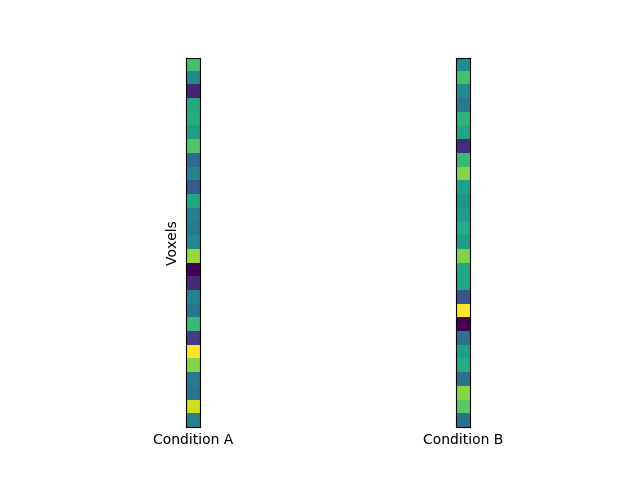

In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pattern_A)
plt.ylabel('Voxels')
plt.tick_params(which='both', left='off', labelleft='off', bottom='off', labelbottom='off')
plt.xlabel('Condition A')
plt.subplot(1,2,2)
plt.imshow(pattern_B)
plt.tick_params(which='both', left='off', labelleft='off', bottom='off', labelbottom='off')
plt.xlabel('Condition B')

*2.3 Generate event time course*

generate_stimfunction can be used to specify the time points at which task stimulus events occur.  The timing of events can be specified by describing the onset and duration of each event. Alternatively, it is possible to provide a path to a 3 column timing file, used by fMRI software packages like FSL, which specifies event onset, duration and weight. 


In [11]:
event_duration = 2
isi = 3
total_time = int(dim[3] * tr)
events = int((total_time - ((event_duration + isi) * 2))  / ((event_duration + isi) * 2)) * 2
onsets_all = np.linspace(0, events * (event_duration + isi), events) 
np.random.shuffle(onsets_all)
onsets_A = onsets_all[:int(events / 2)]
onsets_B = onsets_all[int(events / 2):]
temporal_res = 1.0 # How many timepoints per second of the stim function are to be generated?
stimfunc_A = fmrisim.generate_stimfunction(onsets=onsets_A,
                                           event_durations=[event_duration],
                                           total_time=total_time,
                                           temporal_resolution=temporal_res,
                                           )

stimfunc_B = fmrisim.generate_stimfunction(onsets=onsets_B,
                                           event_durations=[event_duration],
                                           total_time=int(dim[3] * tr),
                                           temporal_resolution=temporal_res,
                                           )

*2.4 Export stimulus time course for analysis*

If a time course of events is generated, as is the case here, it may be useful to store this in a certain format for future analyses. The export_3_column function can be used to export the time course to be a three column (event onset, duration and weight) timing file that might readable to FSL. Alternatively, the export_epoch_file function can be used to export numpy files that are necessary inputs for MVPA and FCMA in BrainIAK.


In [12]:
fmrisim.export_epoch_file(stimfunction=[np.hstack((stimfunc_A, stimfunc_B))],
                          filename=home + '/epoch_file.npy',
                          tr_duration=tr,
                          temporal_resolution=temporal_res,
                          )

fmrisim.export_3_column(stimfunction=stimfunc_A,
                        filename=home + '/Condition_A.txt',
                        temporal_resolution=temporal_res,
                        )

fmrisim.export_3_column(stimfunction=stimfunc_B,
                        filename=home + '/Condition_B.txt',
                        temporal_resolution=temporal_res,
                        )

*2.5 Estimate the voxel weight for each event*

According to the logic of this example, each signal voxel will respond a different amount for condition A and B, but this amount will also differ across voxels. To simulate this we multiply a voxel’s response to each condition by the time course of events and then combine these conditions time courses to make a single time course. This time course describes each voxel’s response to stimuli over time.

In [13]:
weights_A = np.matlib.repmat(stimfunc_A, 1, voxels).transpose() * pattern_A
weights_B = np.matlib.repmat(stimfunc_B, 1, voxels).transpose() * pattern_B
weights_all = weights_A + weights_B
weights_all = weights_all.transpose()

*2.6 Convolve each voxel’s time course with the Hemodynamic Response Function*

With the time course of stimulus events it is necessary to estimate the brain’s response to those events, which can be estimated by convolving it with using a Hemodynamic Response Function (HRF). By default, convolve_hrf assumes a double gamma HRF appropriately models a brain’s response to events, as modeled by fMRI (Friston, et al., 1998). To do this, each voxel’s time course is convolved to make a function of the signal activity. Hence this produces an estimate of the voxel’s activity, after considering the temporal blurring of the HRF. This can take a single vector of events or multiple time courses.

In [14]:
signal_func = fmrisim.convolve_hrf(stimfunction=weights_all,
                                   tr_duration=tr,
                                   temporal_resolution= temporal_res / tr,
                                   scale_function=0,
                                   )

<IPython.core.display.Javascript object>


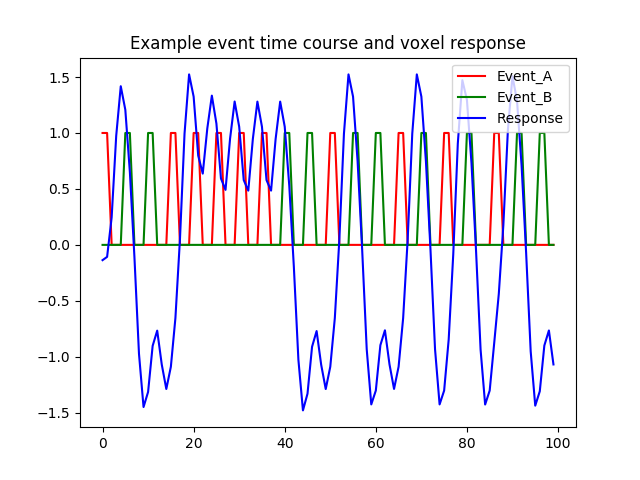

In [15]:
# Display signal
plt.figure()

response = stats.zscore(signal_func[0:100,0])
plt.title('Example event time course and voxel response')
Event_A = plt.plot(stimfunc_A[0:100, 0], 'r', label='Event_A')
Event_B = plt.plot(stimfunc_B[0:100, 0], 'g', label='Event_B')
Response = plt.plot(response, 'b', label='Response')
plt.legend(loc=1)

*2.7 Specify which voxels in the brain contain signal*

fmrisim provides tools to specify certain voxels in the brain that contain signal. The generate_signal function can produce regions of activity in a brain of different shapes, such as cubes, loops and spheres. Alternatively a volume could be loaded in that specifies the signal voxels (e.g. for ROI analyses). The value of each voxel can be specified here, or set to be a random value.

In [16]:
coordinates = np.array([[24, 24, 24]])
signal_volume = fmrisim.generate_signal(dimensions=dim[0:3],
                                        feature_type=['cube'],
                                        feature_coordinates=coordinates,
                                        feature_size=[feature_size],
                                        signal_magnitude=[1],
                                        )

<IPython.core.display.Javascript object>


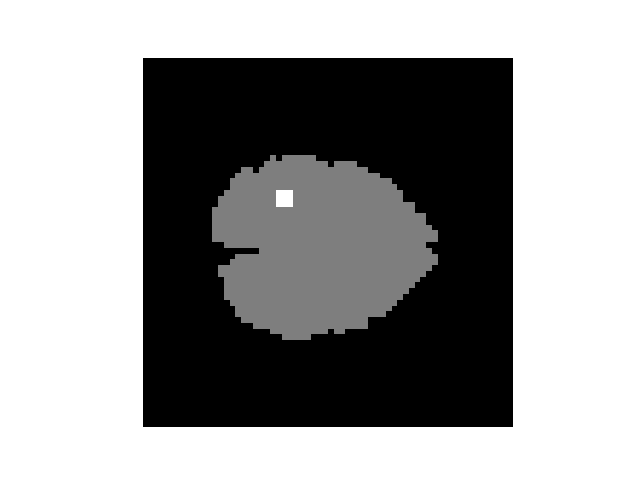

(-0.5, 63.5, 63.5, -0.5)

In [17]:
plt.figure()
plt.imshow(signal_volume[:, :, 24], cmap=plt.cm.gray)
plt.imshow(mask[:, :, 24], cmap=plt.cm.gray, alpha=.5)
plt.axis('off')

*2.8 Multiply the convolved response with the signal voxels*

If you have a time course of simulated response for one or more voxels and a three dimensional volume representing voxels that ought to respond to these events then apply_signal will combine these appropriately. This function multiplies each signal voxel in the brain by the convolved event time course. 


In [18]:
signal = fmrisim.apply_signal(signal_func,
                              signal_volume,
                              )

### **3. Add noise to signal**
fmrisim can generate realistic fMRI noise when supplied with the appropriate inputs. A single function receives these inputs and deals with generating the noise. The necessary inputs are described below; however, the steps performed by this function are also described in detail for clarity.


In [19]:
noise = fmrisim.generate_noise(dimensions=dim[0:3],
                               tr_duration=int(tr),
                               stimfunction_tr=weights_all[::int(tr)], 
                               mask=mask,
                               template=template,
                               noise_dict=noise_dict,
                               )

<IPython.core.display.Javascript object>


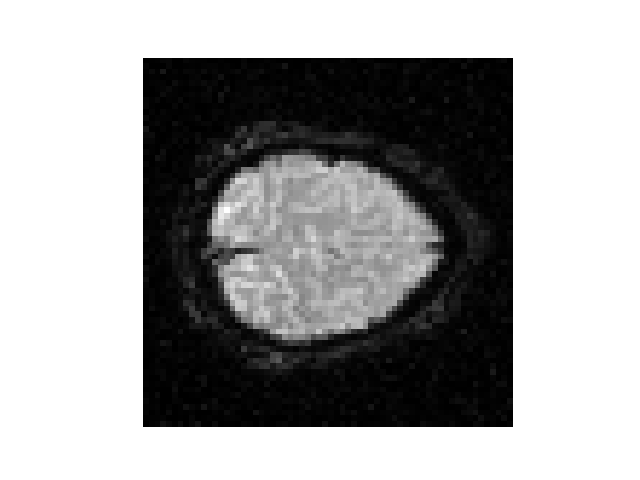

(-0.5, 63.5, 63.5, -0.5)

In [20]:
plt.figure()
plt.imshow(noise[:, :, 24, 0], cmap=plt.cm.gray)
plt.axis('off')

*3.1 Create temporal noise*

The temporal noise of fMRI data is comprised of multiple components: drift, autoregression, task related motion and physiological noise. To estimate drift, a sine wave with a default period of 300s, is used. Although other simulators use a combination of discrete cosines for estimating drift (Welvaert, et al., 2011), our testing suggests that this provides poor estimates in long scans (>200s). This drift is then multiplied by a three-dimensional volume of Gaussian random fields of a specific FWHM. Autoregression noise is estimated by creating a time course of Gaussian noise values that are weighted by previous values of the time course.  This autoregressive time course is multiplied by a brain shaped volume of Gaussian random fields. Physiological noise is modeled by sine waves comprised of heart rate (1.17Hz) and respiration rate (0.2Hz) (Biswal, et al., 1996) with random phase. This time course is also multiplied by brain shaped spatial noise. Finally, task related noise is simulated by adding Gaussian or Rician noise to time points where there are events (according to the event time course) and in turn this is multiplied by a brain shaped spatial noise volume. These four noise components are then mixed together in proportion to the size of their corresponding noise values. This aggregated volume is then Z scored and the SFNR is used to estimate the appropriate standard deviation of these values across time. 
	
*3.2 Create system noise*
    
In addition to temporal noise from fluctuations in the scanner there is also machine noise that causes fluctuations in all voxels. When SNR is low, Rician noise is a good estimate of background noise data (Gudbjartsson, & Patz, 1995). From our testing, when SNR is higher than 30 then noise with an exponential distribution better describes the data. The SNR value that is supplied determines the standard deviation of this machine noise.	

*3.3 Combine noise and template*
    
The template volume is used to estimate the appropriate baseline distribution of MR values. This estimate is then combined with the temporal noise and the system noise to make an estimate of the noise. 

*3.4 Combine signal and noise*

Since the brain signal is expected to be small and sparse relative to the noise, it is assumed sufficient to simply add the volume containing signal with the volume modeling noise to make the simulated brain. 


In [21]:
brain = signal + noise

### **4. Analyse data**

Several tools are available for multivariate analysis in BrainIAK. These greatly speed up computation and are critical in some cases, such as a whole brain searchlight. However, for this example data we will only look at data in the ROI that we know contains signal.

*4.1 Pull out data for each trial*

Identify which voxels are in the signal ROI by using the coordinates provided earlier. To identify the relevant timepoints, assume that the peak of the neural response occurs 4 - 6s after each event onset. Take the TR corresponding to this peak response as the TR for that trial. In longer event/block designs you might instead average over each event.

In [22]:
hrf_lag = 4  # Assumed time from stimulus onset to HRF peak

# Get the lower and upper bounds of the ROI
lb = (coordinates - ((feature_size - 1) / 2)).astype('int')[0]
ub = (coordinates + ((feature_size - 1) / 2) + 1).astype('int')[0]

trials_A = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], (onsets_A + hrf_lag / tr).astype('int')]
trials_B = brain[lb[0]:ub[0], lb[1]:ub[1], lb[2]:ub[2], (onsets_B + hrf_lag / tr).astype('int')]

trials_A = trials_A.reshape((voxels, trials_A.shape[3]))
trials_B = trials_B.reshape((voxels, trials_B.shape[3]))

<IPython.core.display.Javascript object>


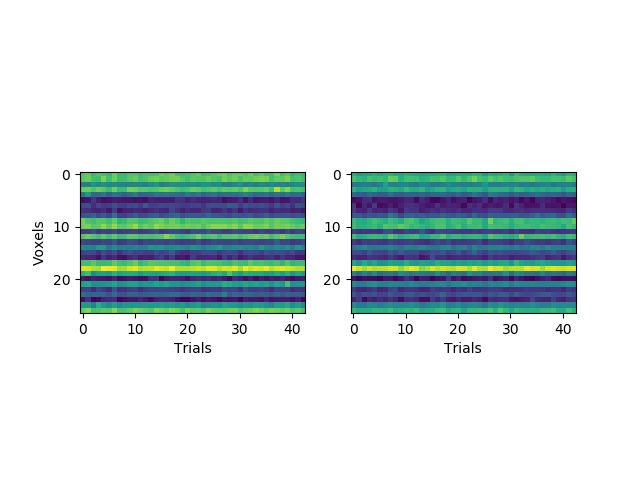

In [23]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(trials_A)
plt.ylabel('Voxels')
plt.xlabel('Trials')
plt.subplot(1,2,2)
plt.imshow(trials_B)
plt.xlabel('Trials')

*4.2 Represent the data*

Treat each voxel as a dimension and each trial as a point in this voxel space. It is then possible to display the different conditions and determine whether these are separable in this lower dimensionality (note that the conditions may be separable in higher dimensionality but unsupervised techniques like Multidimensional Scaling used below, might not show such a difference)

<IPython.core.display.Javascript object>


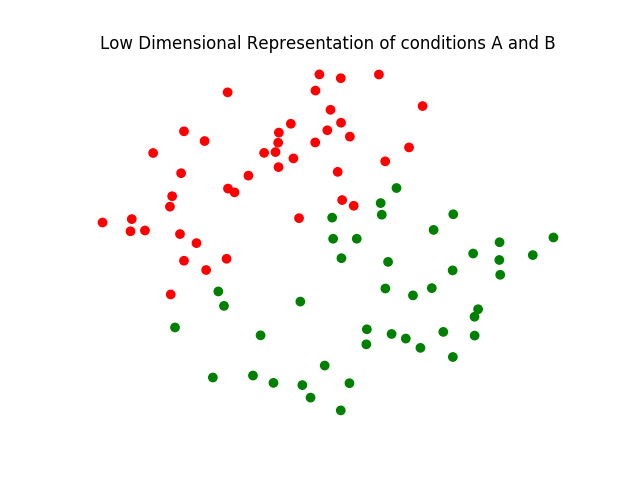

In [24]:
distance_matrix = sp_distance.squareform(sp_distance.pdist(np.vstack([trials_A.transpose(), trials_B.transpose()])))

mds = manifold.MDS(n_components=2, dissimilarity='precomputed')  # Fit the mds object
coords = mds.fit(distance_matrix).embedding_  # Find the mds coordinates
plt.figure()
plt.scatter(coords[:, 0], coords[:, 1], c=['red'] * trials_A.shape[1] + ['green'] * trials_B.shape[1])
plt.axis('off')
plt.title('Low Dimensional Representation of conditions A and B')

*4.2 Test for univariate effect*

Do a t test to compare the means of the voxels between these two conditions to determine if there is a difference

In [25]:
mean_difference = (np.mean(trials_A,0) - np.mean(trials_B,0))
ttest = stats.ttest_1samp(mean_difference, 0)

print('Mean difference between condition A and B: ' + str(mean_difference.mean())[0:5])
print('pvalue: '+ str(ttest.pvalue)[0:5])

Mean difference between condition A and B: -0.52
pvalue: 0.677


*4.3 Test for a multivariate effect*

Use SVM from scikit-learn to estimate the classification accuracy between the conditions

In [26]:
input_mat = np.vstack([trials_A.transpose(), trials_B.transpose()])
input_labels = trials_A.shape[1] * [1] + trials_B.shape[1] * [0]


# Set up the classifier
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    input_mat, input_labels, test_size=0.2, random_state=0)

clf = sklearn.svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

score = clf.score(X_test, y_test)
print('Classification accuracy between condition A and B: ' + str(score)[0:5])

Classification accuracy between condition A and B: 0.833


### **References**
Biswal, B., et al. (1996) Reduction of physiological fluctuations in fMRI using digital filters. Magnetic Resonance in Medicine 35, 107-113

Friedman, L. and Glover, G.H. (2006) Report on a multicenter fMRI quality assurance protocol. Journal of Magnetic Resonance Imaging 23, 827-839

Friston, K.J., et al. (1998) Event-related fMRI: characterizing differential responses. Neuroimage 7, 30-40

Gudbjartsson, H. and Patz, S. (1995) The Rician distribution of noisy MRI data. Magnetic resonance in medicine 34, 910-914

Welvaert, M., et al. (2011) neuRosim: An R package for generating fMRI data. Journal of Statistical Software 44, 1-18
